In [25]:
import cudf
import dask_cudf
import cugraph
import cuspatial
import math
import geopy
import geopandas as gpd
from shapely.geometry import Point
from dask import delayed
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="test_app")
DATA_DIR = "../data/"

In [2]:
# census_data = dask_cudf.read_parquet('../../plotly/plotly-dash-rapids-census-demo/data/census_data.parquet/')
nodes_df = cudf.read_parquet(f'{DATA_DIR}us-nodes.parquet')
edges_df = cudf.read_parquet(f'{DATA_DIR}us-edges.parquet')

In [3]:
def createCircleAroundWithRadius(lat, lon, radiusMiles):
    latArray = []
    lonArray = []

    for brng in range(0,360):
        lat2, lon2 = getLocation(lat,lon,brng,radiusMiles)
        latArray.append(lat2)
        lonArray.append(lon2)

    return lonArray,latArray


def getLocation(lat1, lon1, brng, distanceMiles):
    lat1 = lat1 * math.pi/ 180.0
    lon1 = lon1 * math.pi / 180.0
    #earth radius
    #R = 6378.1Km
    #R = ~ 3959 MilesR = 3959
    R = 3959

    distanceMiles = distanceMiles/R

    brng = (brng / 90)* math.pi / 2

    lat2 = math.asin(math.sin(lat1) * math.cos(distanceMiles) 
    + math.cos(lat1) * math.sin(distanceMiles) * math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(distanceMiles)
    * math.cos(lat1),math.cos(distanceMiles)-math.sin(lat1)*math.sin(lat2))

    lon2 = 180.0 * lon2/ math.pi
    lat2 = 180.0 * lat2/ math.pi

    return lat2, lon2

In [4]:
def get_updated_df(lat,lon, nodes_df):
#     nodes_df = cudf.read_parquet(f'{DATA_DIR}us-nodes.parquet')
    results = cuspatial.point_in_polygon(nodes_df.x, nodes_df.y, cudf.Series([0], index=["selection"]), [0], lat, lon)
    return nodes_df[results.selection]

def get_updated_edges(nodes, edges):
#     edges = cudf.read_parquet(f'{DATA_DIR}us-edges.parquet')
    indices = cudf.logical_and(
        edges.src.isin(nodes.vertex), edges.dst.isin(nodes.vertex),
    )
    return edges[indices]

def get_shortest_paths(edges_df, point_of_interest):
    G_gpu = cugraph.Graph()
    G_gpu.from_cudf_edgelist(edges_df, source='src', destination='dst', edge_attr='time')
    shortest_paths = cugraph.traversal.sssp(G_gpu, point_of_interest)
    shortest_paths = shortest_paths.drop('predecessor', axis=1)
    shortest_paths.columns = ['time', 'vertex']
    return shortest_paths

def get_nearest_node(gdf, point, x='x', y='y', osmid='osmid'):
    gdf = gdf
    gdf['point_y'] = point[0]
    gdf['point_x'] = point[1]
    gdf['distance'] = cuspatial.haversine_distance(gdf[y], gdf[x], 
                                                             gdf['point_y'], gdf['point_x'])
    mask = gdf['distance'] == gdf['distance'].min()
    nearest_node = gdf[mask][osmid].values[0]
    gdf.drop(['point_y', 'point_x', 'distance'], axis=1, inplace=True)
    return nearest_node

def get_polygons_for_travel_time(results, trip_times):
    for trip_time in trip_times:
        results['within_' + str(trip_time)] = 1.0 * (results['time'] < trip_time)

    # make the isochrone polygons
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        mask = results['within_' + str(trip_time)] == 1
        subset = results[mask].to_pandas()
        node_points = [Point((row['x'], row['y'])) for _, row in subset.iterrows()]
        bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull  # TODO use cuspatial
        isochrone_polys.append(bounding_poly)
    return isochrone_polys

from pyproj import Proj, Transformer

In [5]:
def query_census_dataset(polygons, census_data):
    final_polygon = polygons[0]
    for i in polygons:
        final_polygon = final_polygon.union(i)
    lat, lon = final_polygon.exterior.coords.xy
    transform_4326_to_3857 = Transformer.from_crs('epsg:4326', 'epsg:3857')
    lat, lon = transform_4326_to_3857.transform(lat, lon)
    results = cuspatial.point_in_polygon(census_data.x, census_data.y, cudf.Series([0], index=["selection"]), [0], lon, lat)
    return census_data[results.selection]

In [24]:
distanceInMiles = 20
trip_times = [5, 10, 15, 30, 60]

def get_nearest_polygons_from_selected_point(point_lat, point_lon, average_speed):
    lat, lon =  createCircleAroundWithRadius(point_lat, point_lon, distanceInMiles)
    nodes = get_updated_df(lat, lon, nodes_df)
    edges = get_updated_edges(nodes, edges_df)
    meters_per_minute = average_speed * 1000 / 60 # km per hour to m per minute
    edges['time'] = edges['length'] / meters_per_minute
    point_of_interest = get_nearest_node(nodes, point=(point_lat,point_lon), x='x', y='y', osmid='vertex')
    shortest_paths = get_shortest_paths(edges, point_of_interest)
    results = cudf.merge(shortest_paths, nodes[['vertex', 'y', 'x']], on='vertex', how='inner')
    polygons = get_polygons_for_travel_time(results, trip_times)
    del results, shortest_paths, edges, nodes
    return polygons#, delayed(query_census_dataset)(polygons, census_data).compute()

In [26]:
address = geolocator.geocode("175 5th Avenue NYC")

In [28]:
polygons = get_nearest_polygons_from_selected_point(address.latitude, address.longitude, 35)

In [10]:
d = gpd.geodataframe.from_shapely(polygons)

In [11]:
crs = {'init': 'epsg:4326'}
polygon = gpd.GeoDataFrame(index=[0, 1,2, 3, 4], crs=crs, geometry=d).reset_index()      

/home/ajay/anaconda3/envs/spatial_analysis_dev/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [12]:
import pandas as pd

In [13]:
df = pd.DataFrame({'poly': [1,2,3,4,5], 'color':[1,2,3,4,5]})

In [22]:
import plotly.express as px
import json
fig = px.choropleth_mapbox(df, geojson=json.loads(polygon.to_json()), locations='poly', color='color',
                           color_continuous_scale="Viridis",
                           range_color=(0, 5),
                           mapbox_style="carto-positron",
                           opacity=0.5,
                           zoom=9, center = {"lat": address.latitude, "lon": address.longitude},
                          )

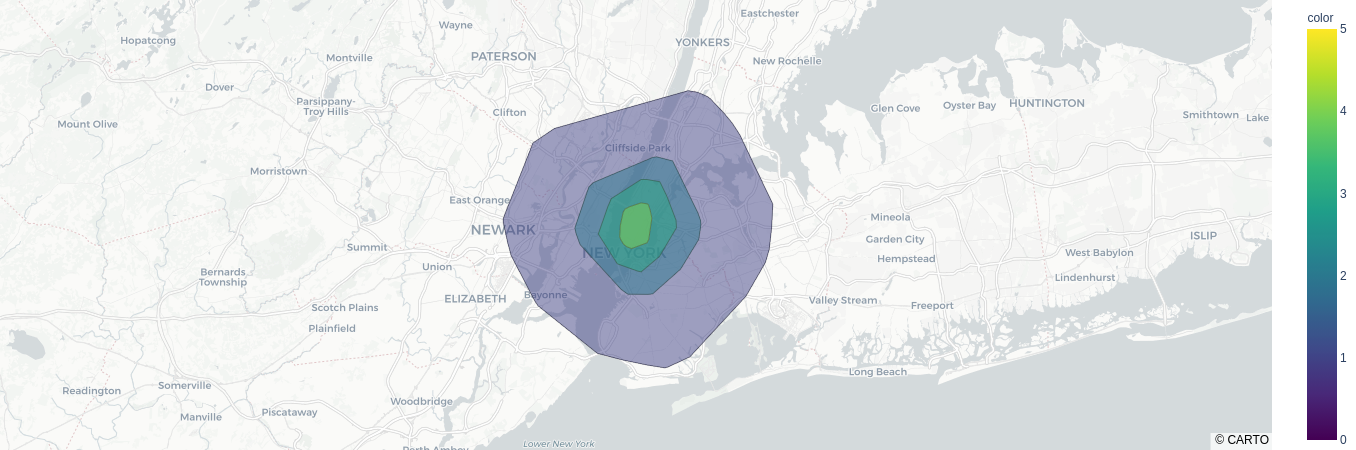

In [23]:
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()